# Set up

Create a regression problem

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
X, y = make_regression(n_samples=1000)

Use a Random Forest to model the problem

In [3]:
model = RandomForestRegressor(oob_score=True, n_estimators=100, n_jobs=-1)

In [4]:
model.fit(X, y)
model.oob_score_

0.75872516794413636

In [5]:
y_hat = model.oob_prediction_

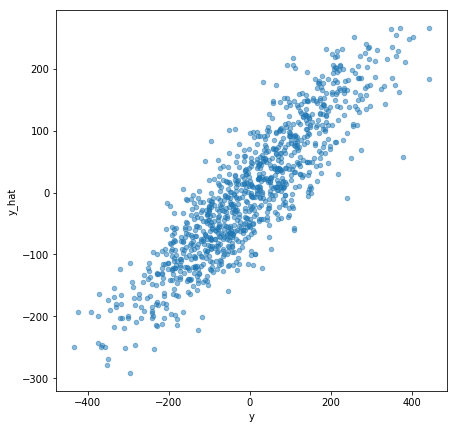

In [6]:
df = pd.DataFrame({
    'y': y,
    'y_hat': y_hat
})

df = df.sort_values(by='y')

df.plot('y', 'y_hat', kind='scatter', alpha=0.5, figsize=(7, 7))

# Use the Transformer to calibrate

In [7]:
from QuantileCalibrator import QuantileCalibrator

In [13]:
qc = QuantileCalibrator(quantile=100, isotonic_fit=True, isotonic_lambda=1)

In [14]:
qc.fit(y_hat, y)

QuantileCalibrator(isotonic_fit=True, isotonic_lambda=1, quantile=100)

In [15]:
df['y_hat2'] = qc.transform(df['y_hat'])

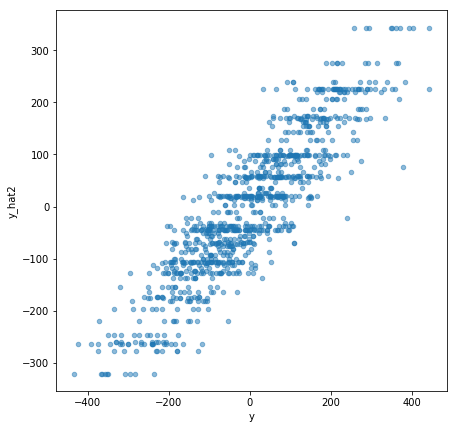

In [16]:
df.plot('y', 'y_hat2', kind='scatter', alpha=0.5, figsize=(7, 7))

In [17]:
r2_score(y, qc.transform(y_hat))

0.79904022278519515

# Cross Validation

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

# Hacky way to change a RandomForest into a Transformer
class RandomForestTransformer(RandomForestRegressor, TransformerMixin):
    
    def transform(self, X, y=None):
        return self.predict(X)

In [21]:
rf = RandomForestTransformer()
qc = QuantileCalibrator()

steps = [
    ('random_forest', rf),
    ('quantile_cal', qc)
]

pipeline = Pipeline(steps=steps)

In [22]:
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('random_forest', RandomForestTransformer(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction...rt=False)), ('quantile_cal', QuantileCalibrator(isotonic_fit=True, isotonic_lambda=1, quantile=10))])

ValueError: Expected 2D array, got 1D array instead:
array=[ -6.58272629e+01  -1.04739052e+02  -2.70547676e+01   2.09461243e+02
   1.65238205e+02  -2.61160950e+02   1.00652977e+02  -1.27243301e+02
   2.03532120e+02   2.59354187e+02   7.57001266e+01   4.20216484e+01
   1.02560707e+02  -1.03737993e+01  -2.84039135e+01   5.42081566e+01
  -4.46505585e+01   3.64787781e+02  -1.70142456e+02   4.79954605e+01
   2.22882748e+01  -1.88817764e+02   3.68775696e+02  -1.15362099e+02
   1.03026459e+02  -1.27477818e+01   2.11569763e+02   3.32862213e+02
   2.11225479e+02   1.40744064e+02   7.51435471e+01   2.32175884e+01
   8.52565079e+01   8.68984222e+01   2.86245789e+02   3.08202896e+01
   1.43688141e+02   2.05641937e+02  -7.50932770e+01  -3.74565430e+02
   4.11399269e+01   7.72344437e+01  -1.93052551e+02  -1.01318199e+02
   7.23775482e+01  -2.50502548e+02  -1.39684189e+02   3.57877441e+02
   5.58816109e+01   1.26966843e+02  -4.34185219e+01  -2.31318405e+02
  -1.14955467e+02   5.77287903e+01   7.95973740e+01  -1.26974007e+02
  -6.75320358e+01  -1.09690308e+02  -2.95275452e+02  -2.14302704e+02
  -2.10268768e+02   2.55027924e+02   7.60590515e+01  -7.26412354e+01
  -1.11521072e+01  -1.08773972e+02   9.64846649e+01  -1.30027361e+01
  -1.44396088e+02  -4.72743187e+01   1.87712431e+00   6.34387894e+01
   2.17660542e+01  -2.25713806e+02   2.41213867e+02  -3.70469322e+01
  -1.06037483e+02   1.47795761e+02   1.84729294e+02  -2.53327530e+02
  -2.39222794e+02  -9.41865387e+01   6.89198914e+01  -5.57798529e+00
   1.85693680e+02  -3.88021126e+01   8.21632996e+01   4.98529091e+01
   2.02203934e+02  -2.12130753e+02  -3.53994263e+02  -7.89269104e+01
   1.56897690e+02   1.40513718e+02  -2.31167526e+02   5.79126968e+01
  -6.95609207e+01   2.34442091e+00   3.77866791e+02  -1.40451187e+02
   3.38644226e+02  -9.19858017e+01   2.03776123e+02  -1.60595627e+02
  -3.98187523e+01  -1.12689362e+02  -1.72688187e+02  -1.01075981e+02
  -3.66119843e+01   9.16563492e+01   8.59703422e-01  -7.73446884e+01
  -1.15559425e+02  -1.51940216e+02   4.36296806e+01   2.31240784e+02
   3.91484337e+01   1.83815899e+01  -1.54497086e+02   1.42524475e+02
  -1.81177612e+02  -6.22775040e+01   2.15130920e+02   1.71263695e+01
  -7.62003098e+01   7.45200577e+01   7.65548630e+01   1.46250320e+02
   6.87276840e+01   1.31316895e+02   2.09459515e+01   2.94895363e+00
  -1.40618873e+00   4.39359131e+01  -9.20919495e+01   2.30368820e+02
  -3.66234932e+01  -2.18228416e+01  -1.61250900e+02   5.35802040e+01
  -2.16984253e+02  -6.30815353e+01   1.82199005e+02   6.19922113e+00
  -4.34019379e+02  -4.28293190e+01  -3.11912575e+01  -1.69057480e+02
  -1.20857147e+02  -9.60573807e+01   1.15552933e+02   2.34351562e+02
  -3.69495430e+01  -6.84494400e+01   1.08338287e+02   2.00567245e+01
  -2.91963776e+02  -3.57509491e+02  -9.91487122e+01  -1.68095154e+02
  -1.77824104e+00  -1.04285011e+02   8.74187469e+01   2.88347351e+02
   2.89980011e+02   3.52669106e+01   4.02998810e+02  -2.29425766e+02
   7.89116745e+01  -2.01987137e+02  -1.94274750e+02   6.69494247e+01
  -4.32724190e+01  -7.10699997e+01   3.49635582e+01   2.32541367e+02
  -1.44427139e+02   4.98604507e+01   1.60965012e+02   6.49291611e+01
  -4.90280037e+01   3.18247948e+01  -9.54148712e+01   1.07972038e+02
  -7.42962418e+01   1.78308884e+02   1.09519501e+02   2.18255325e+02
  -2.06407974e+02   1.38331726e+02  -9.59287567e+01   1.20447741e+01
  -8.72374496e+01  -8.39225235e+01  -2.14262009e+02  -6.27854061e+00
   1.27480629e+02   2.51794449e+02   1.03716873e+02   9.08849869e+01
  -2.41334335e+02   1.69478851e+02  -1.75619030e+01  -1.07392097e+02
   7.03434372e+01   2.72300987e+01   1.43624405e+02  -2.31038330e+02
  -1.26253647e+02  -1.86179688e+02   8.71442642e+01  -3.26988745e+00
   9.54979858e+01   3.61731201e+02   1.52956512e+02   7.74613190e+01
   2.86518250e+02  -1.33692184e+02  -2.48167908e+02  -2.87803436e+02
   1.97466049e+02   6.09008904e+01   4.91864777e+01  -3.71896790e+02
  -1.58805725e+02   2.14841278e+02  -3.09309368e+01   8.48593216e+01
   1.87058960e+02  -8.86661377e+01   1.46485931e+02   8.64180603e+01
   2.85556519e+02   6.50832939e+00   7.51802492e+00   2.22295322e+01
  -5.27328148e+01   5.74905586e+01  -4.51162415e+01  -2.07705856e+02
   1.11094978e+02   1.72800491e+02   9.65011063e+01   2.72184174e+02
   6.65756760e+01  -2.13002121e+02   7.42508774e+01   1.10660187e+02
   2.81417980e+01  -1.29546265e+02  -1.65855240e+02   1.34082626e+02
  -6.69455872e+01   1.76019440e+02  -2.28722427e+02  -3.44558220e+01
  -2.30348969e+02  -5.45906496e+00   2.21695679e+02   2.09749237e+02
  -1.52618729e+02   2.94891296e+02  -9.83260345e+01   2.14331650e+02
  -1.51537201e+02  -2.64946899e+02   6.99997025e+01   3.47593140e+02
   8.39070206e+01  -1.19211912e+01  -2.17607773e+02   1.44500656e+02
  -5.07036209e+01   1.00580185e+02   1.00616013e+02   1.75936874e+02
   1.40376938e+02   1.66383820e+01  -2.42808838e+02   2.14153564e+02
   1.05250145e+02  -4.33281593e+01  -1.92129547e+02   4.38274574e+01
   7.72568893e+01  -1.55279114e+02  -1.26637848e+02   6.62928162e+01
  -1.36157364e+02   1.15202118e+02   1.00837334e+02  -4.88058624e+01
   1.54797577e+02  -8.89279327e+01  -7.41281357e+01  -9.56767807e+01
  -1.00650826e+02   8.08519669e+01   8.97872467e+01  -1.00747406e+02
   9.07208443e+00   1.30550522e+02  -3.92642029e+02   1.84377441e+02
  -1.31978058e+02   2.98946571e+01  -3.73840599e+01   2.22886230e+02
  -8.93222351e+01  -3.15969505e+01  -1.90066605e+01   4.97179222e+01
  -2.04550583e+02   1.32917953e+02   1.42217102e+02   7.54734421e+01
   7.47133827e+00   3.70113029e+01  -7.98471832e+01  -1.98411774e+02
  -1.23225632e+01   1.45820557e+02   5.09861679e+01   1.14025993e+02
  -1.78776627e+02  -2.41483261e+02  -2.06511292e+02   1.83339172e+02
  -1.89095795e+02  -1.46078751e+02  -7.20925980e+01  -6.31230659e+01
   1.73102798e+01   1.48561630e+02  -1.34464127e+02  -3.10833573e+00
  -5.66801224e+01  -2.74922485e+02  -2.90180359e+01  -1.28942001e+02
   3.13071960e+02  -5.10218773e+01  -1.40163177e+02   9.81342773e+01
  -1.61196899e+01   1.23200844e+02   7.86481323e+01  -2.50062973e+02
  -3.21793579e+02   3.30705383e+02  -1.18137581e+02  -2.28238144e+02
  -1.66035309e+02  -2.74121037e+01   7.34734344e+01   2.20202789e+01
  -1.73720215e+02  -1.22829720e+02  -1.45767975e+02  -2.78585510e+01
   5.95122948e+01  -1.08731018e+02  -3.20229263e+01  -1.10353500e+02
   1.80858215e+02   1.21012985e+02  -7.74980316e+01   2.95882141e+02
  -1.26410675e+02   1.09553709e+01  -1.92920227e+02  -4.73411274e+00
   1.27365143e+02   1.11641151e+02   7.78270187e+01  -5.55993118e+01
   6.53772583e+01  -3.11141144e+02   1.31033188e+02   3.86178970e+01
  -1.04352562e+02   1.61003616e+02   1.36257401e+02  -1.10326324e+02
   1.37333755e+02  -3.20355835e+02  -1.81375381e+02   4.61217270e+01
  -2.96264153e+01  -1.36047150e+02   6.42644348e+01  -2.11947205e+02
   1.45764313e+02   8.88167725e+01  -7.41451416e+01  -6.54713135e+01
  -1.63332796e+00   1.80338470e+02   1.72286621e+02  -6.71410370e+01
  -4.62242622e+01   4.62314987e+01  -1.64636780e+02  -2.47695282e+02
   1.22537178e+02   2.44550400e+01  -7.38320465e+01   9.33242722e+01
  -9.72104187e+01   1.15842621e+02   1.67496460e+02   1.65652451e+02
  -7.63964920e+01  -1.69042099e+02  -1.88637006e+00  -1.32548279e+02
  -1.02302261e+02   2.33167603e+02  -9.35969620e+01   2.68614868e+02
   3.09596649e+02   2.03157501e+02  -1.15932823e+02   1.75361156e+01
  -5.81133423e+01   2.74382446e+02  -2.84469967e+01  -2.82897739e+01
  -1.90568848e+02  -3.97842522e+01   4.29941025e+01  -5.03378258e+01
   1.07483282e+01  -2.73526936e+01  -1.46013290e+02   2.48080802e+00
   1.69429031e+02  -1.43404907e+02   3.76889648e+01  -9.71809006e+01
  -1.46137283e+02   1.85387020e+01   2.43957153e+02  -1.81382050e+02
  -1.40488678e+02   1.16968842e+02   3.13703442e+01  -9.90443878e+01
  -9.89308777e+01  -4.70308495e+01   2.45664349e+01  -1.56003571e+02
  -9.69666290e+00   8.96622009e+01  -1.85488617e+02  -8.33524094e+01
   2.77898376e+02   7.51245117e+01   1.16807953e+02   1.11670898e+02
  -1.81509003e+02   5.19812317e+01  -5.63712349e+01  -2.74764118e+01
   7.21138382e+01   1.88849213e+02   1.63350735e+01  -3.31766205e+02
   7.84887695e+00   2.60585144e+02   1.44524689e+02  -7.67530251e+00
   1.98374039e+02  -9.72251968e+01  -9.61609554e+00   2.64601532e+02
  -1.50103210e+02  -6.74711761e+01  -2.52670914e+02   3.81291809e+01
  -1.71395187e+02   3.25904198e+01  -6.64904327e+01   2.83995422e+02
   5.12925034e+01   2.56705074e+01   1.93678970e+02  -1.20245333e+01
   1.88984222e+02  -1.93564892e-01   2.06471825e+00  -1.80646500e+02
  -2.84579163e+02   6.74360352e+01   1.03152908e+02  -2.00585880e+01
  -2.75640182e+01  -4.07553940e+01  -2.15909317e+02   6.14180222e+01
   2.18644897e+02  -2.08261688e+02  -1.37398560e+02  -1.54233414e+02
   1.87363953e+02  -2.35585079e+01  -1.41863693e+02   1.64139999e+02
   1.08478531e+02  -1.63503967e+02   1.47142151e+02  -1.07017853e+02
   2.56538727e+02  -1.38465977e+01   1.93768600e+02  -1.53706940e+02
   3.61106873e+02   5.17947617e+01   1.33022659e+02   1.74361938e+02
   1.69907516e+02  -4.69996948e+01  -2.82078857e+02   1.75346863e+02
  -2.10155228e+02  -8.66786499e+01  -1.00027761e+01  -5.08420258e+01
   1.41738693e+02  -4.95918617e+01   3.10520840e+01   9.70518875e+01
  -7.83735886e+01   1.70990555e+02   1.18747452e+02   9.94426270e+01
   3.56944542e+01   1.62525299e+02  -1.20010483e+02   1.16427795e+02
  -2.72345715e+01   6.35309296e+01  -2.03341751e+02   4.45523758e+01
  -1.15374016e+02  -6.35529747e+01  -7.26374741e+01   2.39976807e+01
   1.17367830e+01   1.77995651e+02   1.80341583e+02   2.93696503e+02
   1.65970551e+02  -3.17447281e+01  -3.34776947e+02   1.79600723e+02
   8.12766418e+01  -5.62114639e+01   6.09075127e+01   2.20415192e+02
  -9.28764191e+01   5.42707367e+01   2.15663651e+02  -5.92755394e+01
  -3.34921997e+02  -3.02063080e+02  -4.57534943e+01   6.67632446e+01
  -3.17620178e+02   1.24431160e+02   2.82923050e+01   2.90937958e+02
  -5.70844460e+01   4.60971947e+01   2.07523544e+02  -1.01443535e+02
   1.93480759e+01   1.25131340e+02   1.09013367e+02   1.20723282e+02
   2.33625107e+02  -1.47060852e+01  -3.00456390e+02   2.39713806e+02
   3.23351936e+01   1.39942505e+02  -4.13373489e+01  -3.45942676e-01
  -2.86153503e+02   8.54805984e+01  -1.44518295e+02  -1.85162125e+02
   1.19832405e+02  -1.08712494e+02   2.35118027e+01  -1.48474569e+01
  -9.61574554e+01  -1.36148621e+02   1.11980690e+02  -6.36688690e+01
  -1.86533768e+02   7.78424988e+01   5.73154736e+00  -1.49011269e+01
  -8.19312897e+01  -2.61369019e+02  -6.44930420e+01   9.76735611e+01
  -1.87070999e+02   6.32503471e+01   2.21497437e+02   2.83630238e+01
   2.09872665e+02  -3.51393982e+02  -1.01750793e+02   1.41248245e+02
   1.10224937e+02  -1.31207565e+02  -5.34185944e+01   1.47711799e-01
  -1.86218964e+02  -5.32780571e+01  -7.78729172e+01  -3.86822701e+01
   1.77122131e+02  -2.41962402e+02   1.87493382e+01   1.72202587e+01
   9.49834061e+01  -9.44263840e+01  -2.57731706e-01  -7.93482666e+01
  -1.19517868e+02  -2.25913757e+02   2.59245544e+02   2.15549603e+01
   5.04287958e+00   4.94591637e+01   6.92021866e+01   6.10973206e+01
   1.81469119e+00   8.57253494e+01  -1.32965805e+02  -3.13903046e+01
  -3.08586670e+02   7.58176270e+01  -1.19443558e+02   1.49936554e+02
  -8.21531219e+01  -3.36632805e+01  -5.97809067e+01  -1.70107178e+02
  -1.26729889e+02  -4.18526192e+01  -3.52674713e+01  -1.92148575e+02
  -1.10792686e+02  -1.47771179e+02  -5.51782494e+01   1.00067986e+02
  -9.05047531e+01  -6.36682129e+01   5.74555092e+01  -1.93498825e+02
  -9.88704224e+01  -1.01443581e+02   2.77298188e+00   6.98869324e+01
  -1.80368328e+01  -1.15298950e+02   6.48496628e+01   3.50540527e+02
  -1.06248482e+02  -4.45748634e+01  -3.40695305e+01   1.07841667e+02
  -2.37389130e+02  -2.83874969e+02   3.70785904e+01  -9.62289581e+01
  -1.50199747e+01  -1.73018951e+02   1.92895004e+02   1.72831924e+02
  -1.27673935e+02  -1.39077805e+02  -6.59642944e+01  -5.43616600e+01
   1.21715034e+02   3.99774051e+00   1.44289200e+02  -6.13006020e+01
   6.66079903e+00  -1.31657104e+02   4.07905922e+01   6.96832352e+01
  -1.78882294e+02   1.00025230e+02   2.28631805e+02   1.06939491e+02
   1.38604584e+02  -1.30704666e+02   1.11228027e+01  -7.88196106e+01
  -1.05776901e+02   1.80848923e+02  -5.22283325e+01  -4.94249115e+01
  -2.30469772e+02  -3.46557770e+01  -3.42254181e+01   1.05491577e+02
  -4.47936211e+01  -1.03393181e+02  -1.11424313e+01   3.51835968e+02
   1.06055969e+02   1.39667831e+02  -3.10984135e+01   4.28156319e+01
   3.06038113e+01  -3.66709785e+01   2.09235641e+02  -1.87177795e+02
  -2.42422089e+02  -2.17149902e+02   2.00681496e+00  -5.57148285e+01
   1.40254837e+02  -1.94237946e+02  -9.91796265e+01  -3.04391098e+00
   7.59218445e+01  -1.21413559e+02  -1.71552032e+02  -3.35253296e+02
  -1.65700073e+02   1.80502777e+02  -7.58802567e+01  -8.62737427e+01
  -4.84611549e+01  -9.60080795e+01  -1.08472008e+02  -1.22397766e+01
   3.27698250e+01  -3.15418304e+02   1.18503853e+02  -3.31483498e+01
   2.04297775e+02  -9.76225815e+01   2.66452209e+02   9.76219482e+01
   2.64086487e+02   1.61503006e+02  -7.88877945e+01   1.49713593e+02
   1.23328354e+02  -1.08198690e+01   1.45735977e+02   8.65590668e+01
   2.83604675e+02  -9.44281616e+01  -1.12240276e+01   1.62488449e+02
   3.87264938e+01   1.48331009e+02  -2.75703182e+01  -7.02872086e+01
  -1.37240982e+02   1.74209412e+02  -5.68740005e+01   4.21721725e+01
   2.55586182e+02  -1.96766739e+02   1.07533783e+02   2.13496780e+02
   2.86930656e+01  -1.96299706e+01  -2.14499619e+02  -7.63325806e+01
  -5.07733383e+01  -1.85405869e+02  -3.51243683e+02   1.74218643e+02
  -1.47399918e+02  -2.16617966e+02   6.12307968e+01  -1.01567711e+02
  -1.28696152e+02   2.21967392e+02  -3.79100266e+01   1.05711205e+02
  -1.81651367e+02  -1.61459122e+02  -5.03806076e+01   1.67522125e+02
  -3.53063354e+01  -3.87150269e+01   8.07386627e+01  -2.16465012e+02
  -1.57992538e+02   1.66398132e+02   7.39492798e+01  -2.95577606e+02
   5.86133842e+01  -1.59660004e+02  -1.87110687e+02  -1.36997894e+02
  -2.45615326e+02  -5.33548088e+01   1.74005249e+02   2.26786957e+01
   2.29672882e+02   4.67746964e+01  -7.15355606e+01  -7.73028717e+01
   1.11809113e+02   2.54882908e+01   1.91657196e+02  -4.22235909e+01
  -1.58976242e+02   4.72716560e+01   1.41251556e+02  -1.06418791e+01
  -1.92100342e+02  -3.74746521e+02  -6.43091965e+01   2.31633514e+02
   2.01138515e+01  -1.15300156e+02  -9.58602905e+01   6.80759430e+01
   2.14215179e+02  -1.98240433e+02  -1.61122498e+02   7.28844376e+01
   5.04382210e+01   4.67258568e+01  -9.37541294e+00   1.82361343e+02
   4.56363373e+01  -1.89240479e+02   2.34646378e+01   1.87719202e+00
   2.96864594e+02  -8.73233795e+01   8.61125488e+01  -8.15784912e+01
   5.76577034e+01   2.66901031e+02   2.13448975e+02  -5.29725342e+01
   2.25560760e+01   3.22147293e+01  -1.06068977e+02   2.65953217e+02
   1.24721703e+02  -3.30367096e+02  -1.35294403e+02  -1.35421600e+02
  -8.30468826e+01  -7.54988327e+01   2.38810242e+02   6.96456146e+01
   8.10254745e+01  -1.87915974e+01  -2.73125580e+02  -1.66214111e+02
  -2.67904175e+02  -1.10543495e+02  -1.28050140e+02   1.96826218e+02
  -2.67928528e+02   2.45912762e+01   1.53823135e+02  -9.46693649e+01
   3.09214294e+02  -1.57694092e+01  -1.19329880e+02   1.27620285e+02
   2.75371429e+02  -9.88423386e+01   4.41119354e+02  -5.28359604e+01
   8.11908436e+00  -1.95552719e+02   1.39301620e+02  -1.50651154e+02
   1.53101339e+01   2.06040955e+02   2.19565262e+02  -8.04339218e+01
  -1.57510330e+02  -1.41104828e+02  -1.82181107e+02   2.34831257e+01
   8.88493500e+01  -3.45031281e+02   1.92233246e+02   8.67747498e+01
  -1.84398636e+02   7.76028204e+00   3.70024834e+01  -2.43076420e+00
  -6.04325943e+01  -1.51977249e+02  -4.84303360e+01   3.92871735e+02
  -1.37732620e+02  -7.01254416e+00   9.85479660e+01   2.33512211e+01
  -9.72538528e+01  -7.80396118e+01   7.08420410e+01  -2.38640106e+02
   3.82861633e+02  -1.85341232e+02  -2.22303944e+01   9.42906036e+01
  -3.17531769e+02  -1.04791306e+02  -1.92537476e+02   1.72128916e+00
  -9.23724213e+01   2.70090027e+02  -4.95027733e+01  -1.57155838e+02
   6.68374405e+01   1.00458763e+02  -1.87176743e+02  -1.29619705e+02
   3.80517998e+01  -5.51915169e+01  -3.65710938e+02  -8.34954262e+00
  -7.39539413e+01  -7.22041626e+01   8.07702637e+01  -9.99420395e+01
   1.52738312e+02  -3.95504913e+01   1.20853996e+02  -1.48976990e+02
  -7.84503708e+01  -4.25000275e+02  -1.64254379e+02   1.54495227e+00
   1.87419647e+02  -1.20430595e+02   5.13750916e+01   1.64851296e+00
  -2.02281677e+02   1.23733311e+01   2.41361332e+01   8.08559113e+01
   3.17203732e+01   5.97236099e+01  -1.50832474e+02  -5.38502007e+01
  -1.20249634e+02  -1.46555462e+01  -2.35308971e+01  -1.26097771e+02
  -1.05595596e+02   9.61982918e+00  -1.73515701e+02  -1.29936295e+02
   9.31629791e+01   1.87573624e+02   4.42745758e+02  -2.06519699e+01
   4.66008644e+01  -7.85175705e+01   2.71280060e+02   1.23957680e+02
   1.30693970e+02   1.26332951e+01   2.48305645e+01   1.58079330e+02
  -1.77961258e+02   2.39792786e+02  -1.46174698e+01   3.23285248e+02
   2.48857849e+02   1.35621872e+02  -3.67855682e+02  -5.64627876e+01
  -1.32827225e+01   6.29684830e+01   1.86532001e+01  -1.36525818e+02
   9.76407928e+01  -5.04607582e+01  -5.94809113e+01  -5.28123512e+01
   3.71692688e+02  -4.24592285e+01   1.19872551e+02  -3.91969132e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.